In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize
from sklearn.cluster import KMeans, MiniBatchKMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C://duh/Thinkful/Thinkful/Exercises/Medium_AggregatedData.csv')

In [3]:
df.head()

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,...,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,...,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,...,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [4]:
df = df[['text', 'title', 'author', 'language']]
df.drop_duplicates(subset='text', inplace=True)
df.drop(df.index[df.language != 'en'], inplace=True)
authors = df.author.value_counts()[:10].index.to_list()
df = df[df.author.isin(authors)]
df = df.reset_index(drop=True)

In [5]:
df.head()

,text,title,author,language
0,How Machine Learning is Revolutionizing Digita...,How Machine Learning is Revolutionizing Digita...,Yves Mulkers,en
1,"Tech & Telecom news — Mar 2, 2018\nPRODUCTS & ...","Tech & Telecom news — Mar 2, 2018",C Gavilanes,en
2,AI Biweekly: 10 Bits from May W3 — May W4\n\n\...,AI Biweekly: 10 Bits from May W3 — May W4,Synced,en
3,Pittsburgh’s Pivot to Artificial Intelligence\...,Pittsburgh’s Pivot to Artificial Intelligence,Synced,en
4,"Tech & Telecom news — Jun 14, 2018\nPRODUCTS &...","Tech & Telecom news — Jun 14, 2018",C Gavilanes,en


In [6]:
df.shape

(2024, 4)

In [7]:
nlp = spacy.load('en')
df['doc'] = None
df['bow'] = None

sentences = pd.DataFrame()

In [8]:
df.head()

,text,title,author,language,doc,bow
0,How Machine Learning is Revolutionizing Digita...,How Machine Learning is Revolutionizing Digita...,Yves Mulkers,en,None,None
1,"Tech & Telecom news — Mar 2, 2018\nPRODUCTS & ...","Tech & Telecom news — Mar 2, 2018",C Gavilanes,en,None,None
2,AI Biweekly: 10 Bits from May W3 — May W4\n\n\...,AI Biweekly: 10 Bits from May W3 — May W4,Synced,en,None,None
3,Pittsburgh’s Pivot to Artificial Intelligence\...,Pittsburgh’s Pivot to Artificial Intelligence,Synced,en,None,None
4,"Tech & Telecom news — Jun 14, 2018\nPRODUCTS &...","Tech & Telecom news — Jun 14, 2018",C Gavilanes,en,None,None


In [9]:
df.shape

(2024, 6)

In [10]:
for x in range(len(df.text)):
    if x % 250 == 0:
        print("Processing row {}".format(x))
    #df.text[x] = re.sub(df.title[x], '', df.text[x])
    df.text[x] = df.text[x].lower()
    df.text[x] = re.sub('https://*.*?\\n', ' ', df.text[x])
    df.text[x] = re.sub('http://*.*?\\n', ' ', df.text[x])
    df.text[x] = re.sub('\\n', ' ', df.text[x])
    df.text[x] = re.sub('bibliography.*', '', df.text[x])
    df.text[x] = re.sub('[%s]' % re.escape(string.punctuation), '', df.text[x])
    df.text[x] = re.sub('\w*\d\w*', '', df.text[x])
    df.text[x] = re.sub('’', '', df.text[x])
    df.text[x] = re.sub('—', ' ', df.text[x])
    df.text[x] = re.sub('”', '', df.text[x])
    df.text[x] = re.sub('“', '', df.text[x])
    df.text[x] = re.sub('‘', '', df.text[x])
    df.text[x] = re.sub('€', '', df.text[x])
    df.text[x] = re.sub('…', ' ', df.text[x])
    df.text[x] = re.sub('\ \ ', ' ', df.text[x])
    df.text[x] = re.sub('quest ce quune classe concrete google search févr la figure suivante représente nos classes classe animal nous avons bien notre classe mère animal et wwwgoogleie les décorateurs python est un langage de programmation qui nécessite décrire moins de lignes de code que le c ou le c il se veut openclassroomscom objet est une instance de classe google search en programmation orientée objet on appelle instance dune classe un objet avec un comportement et un état tous deux wwwgoogleie classe abstraite google search classe abstraite et interface quest ce quune classe abstraite une classe abstraite est une classe incomplète elle wwwgoogleie creer une classe python google search nov nous allons aussi essayer de comprendre les mécanismes de la programmation orientée objet en python wwwgoogleie première approche des classes python est un langage de programmation qui nécessite décrire moins de lignes de code que le c ou le c il se veut openclassroomscom', '', df.text[x])
    df.text[x] = df.text[x].strip()
    if df.text[x] == '':
        df.drop([x], inplace=True)
        df = df.reset_index(drop=True)

Processing row 0
Processing row 250
Processing row 500
Processing row 750
Processing row 1000
Processing row 1250
Processing row 1500
Processing row 1750
Processing row 2000


In [11]:
df.head()

,text,title,author,language,doc,bow
0,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,Yves Mulkers,en,None,None
1,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",C Gavilanes,en,None,None
2,ai biweekly bits from may may may fujitsu a...,AI Biweekly: 10 Bits from May W3 — May W4,Synced,en,None,None
3,pittsburghs pivot to artificial intelligence s...,Pittsburgh’s Pivot to Artificial Intelligence,Synced,en,None,None
4,tech telecom news jun products services vide...,"Tech & Telecom news — Jun 14, 2018",C Gavilanes,en,None,None


In [12]:
df.shape

(2024, 6)

In [13]:
for x in range(len(df.text)):
    df.doc[x] = nlp(df.text[x])

In [14]:
sentences = df[['doc', 'author']]

In [15]:
sentences.head()

,doc,author
0,"(how, machine, learning, is, revolutionizing, ...",Yves Mulkers
1,"(tech, telecom, news, , mar, , products, ser...",C Gavilanes
2,"(ai, biweekly, bits, from, may, , may, , may...",Synced
3,"(pittsburghs, pivot, to, artificial, intellige...",Synced
4,"(tech, telecom, news, , jun, , products, ser...",C Gavilanes


In [16]:
sentences.shape

(2024, 2)

In [17]:
def bag_of_words(text):
    
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    return [item[0] for item in Counter(allwords).most_common(25)]
    

def bow_features(sentences, common_words):
    
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences['doc']
    df['text_source'] = sentences['author']
    df.loc[:, common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):

        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        for word in words:
            df.loc[i, word] += 1
        
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [18]:
for x in range(len(df.text)):
    df.bow[x] = bag_of_words(df.doc[x])

In [19]:
df.head()

,text,title,author,language,doc,bow
0,how machine learning is revolutionizing digita...,How Machine Learning is Revolutionizing Digita...,Yves Mulkers,en,"(how, machine, learning, is, revolutionizing, ...","[ml, business, machine, technology, datum, ent..."
1,tech telecom news mar products services vide...,"Tech & Telecom news — Mar 2, 2018",C Gavilanes,en,"(tech, telecom, news, , mar, , products, ser...","[story, new, app, company, mobile, service, an..."
2,ai biweekly bits from may may may fujitsu a...,AI Biweekly: 10 Bits from May W3 — May W4,Synced,en,"(ai, biweekly, bits, from, may, , may, , may...","[ai, , intel, centre, develop, library, solut..."
3,pittsburghs pivot to artificial intelligence s...,Pittsburgh’s Pivot to Artificial Intelligence,Synced,en,"(pittsburghs, pivot, to, artificial, intellige...","[professor, robotic, robot, pittsburgh, year, ..."
4,tech telecom news jun products services vide...,"Tech & Telecom news — Jun 14, 2018",C Gavilanes,en,"(tech, telecom, news, , jun, , products, ser...","[story, app, new, announce, service, video, ga..."


In [20]:
common_words = set()
for x in range(len(df.text)):
    common_words.update(df.bow[x])

In [21]:
len(common_words)

6898

In [22]:
aa = sentences[:100]
ab = sentences[100:200]
ac = sentences[200:300]
ad = sentences[300:400]
ae = sentences[400:500]
af = sentences[500:600]
ag = sentences[600:700]
ah = sentences[700:800]
ai = sentences[800:900]
aj = sentences[900:1000]
ak = sentences[1000:1100]
al = sentences[1100:1200]
am = sentences[1200:1300]
an = sentences[1300:1400]
ao = sentences[1400:1500]
ap = sentences[1500:1600]
aq = sentences[1600:1700]
ar = sentences[1700:1800]
at = sentences[1800:1900]
au = sentences[1900:]
aa = aa.reset_index(drop=True)
ab = ab.reset_index(drop=True)
ac = ac.reset_index(drop=True)
ad = ad.reset_index(drop=True)
ae = ae.reset_index(drop=True)
af = af.reset_index(drop=True)
ag = ag.reset_index(drop=True)
ah = ah.reset_index(drop=True)
ai = ai.reset_index(drop=True)
aj = aj.reset_index(drop=True)
ak = ak.reset_index(drop=True)
al = al.reset_index(drop=True)
am = am.reset_index(drop=True)
an = an.reset_index(drop=True)
ao = ao.reset_index(drop=True)
ap = ap.reset_index(drop=True)
aq = aq.reset_index(drop=True)
ar = ar.reset_index(drop=True)
at = at.reset_index(drop=True)
au = au.reset_index(drop=True)

In [49]:
word_counts = pd.DataFrame()

In [75]:
word_counts = word_counts.append(bow_features(au, common_words), ignore_index=True)

Processing row 0
Processing row 50
Processing row 100


In [76]:
word_counts.shape

(2024, 6900)

In [77]:
word_counts.head()

,raisina,elementwise,codevisualstudiocom,publisher,posterior,groundwork,probability,villani,applicationscope,message,...,potential,timeline,reviewer,country,decentralization,target,jaywalking,ad,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(how, machine, learning, is, revolutionizing, ...",Yves Mulkers
1,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,"(tech, telecom, news, , mar, , products, ser...",C Gavilanes
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(ai, biweekly, bits, from, may, , may, , may...",Synced
3,0,0,0,0,0,0,0,0,0,1,...,2,0,0,0,0,0,0,0,"(pittsburghs, pivot, to, artificial, intellige...",Synced
4,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,"(tech, telecom, news, , jun, , products, ser...",C Gavilanes


In [78]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0,
                                                    stratify=Y)

In [79]:
#X_norm = normalize(X)

#pca = PCA(.95)
#X_pca = pca.fit_transform(X_norm)

svd= TruncatedSVD(10)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(X)

# Calculate predicted values.
y_pred = KMeans(random_state=0).fit_predict(X_lsa)

In [80]:
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 35.44221271584689


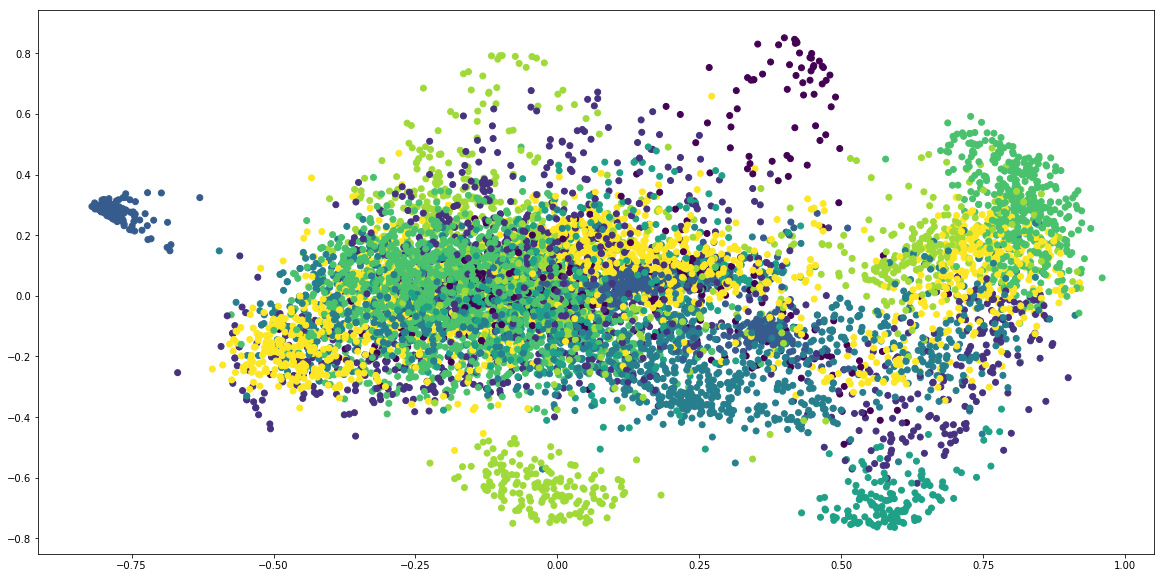

In [84]:
plt.figure(figsize=(20,10))
plt.scatter(X_lsa[:, 0], X_lsa[:, 1], c=y_pred)
plt.scatter(X_lsa[:, 2], X_lsa[:, 3], c=y_pred)
plt.scatter(X_lsa[:, 4], X_lsa[:, 5], c=y_pred)
plt.scatter(X_lsa[:, 6], X_lsa[:, 7], c=y_pred)
plt.scatter(X_lsa[:, 8], X_lsa[:, 9], c=y_pred)
plt.show()

In [85]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
        
print('Training score: ', lr.score(X_train, y_train))
print('Test score: ', lr.score(X_test, y_test))

Training score:  1.0
Test score:  0.9790123456790123


In [86]:
svm = SVC(kernel='linear')
train = svm.fit(X_train, y_train)

print('Training score: ', svm.score(X_train, y_train))
print('Test score: ', svm.score(X_test, y_test))

Training score:  1.0
Test score:  0.9765432098765432
